In [70]:
import cupy as cp
import matplotlib.pyplot as plt
from functions import R,RT,mshow_complex,mshow
from phantom import *

# load object, the object should be complex64

In [71]:
theta = (cp.load('tovictor/ang1.npy').astype('float32'))[:]
data = (cp.load('tovictor/prj1diff.npy').astype('float32'))[:,:160,:160].swapaxes(0,1)
rotation_axis = 80
w_shape = [data.shape[0],data.shape[2],data.shape[2],3]
data_shape = data.shape


# Make operators

### $F_1(w,\theta) = \mathcal{R}_\theta (w_x) \cos\theta + \mathcal{R}_\theta (w_y) \sin\theta$

how is it defined for 3D?

In [72]:
def F1(w):
    Rw = cp.zeros(data_shape,dtype='float32')
    t = [-cp.cos(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis]]###???    
    for k in range(3):
        Rw += t[k]*R(w[...,k].astype('complex64'),theta,rotation_axis).real
    return Rw
   
def F1adj(Rw):
    t = [-cp.cos(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis],
        -cp.sin(theta)[:,cp.newaxis]]###???
    w = cp.zeros(w_shape,dtype='float32')
    for k in range(3):
        w[...,k] = RT((Rw*t[k]).astype('complex64'),theta,rotation_axis).real
    return w

### Adjoint test

In [73]:
a = cp.random.random(w_shape,dtype='float32')
b = cp.random.random(data_shape,dtype='float32')
bb = F1(a)
aa = F1adj(b)
print(cp.sum(aa*a))
print(cp.sum(bb*b))

-213497.02
-213497.1


### $ F_{21}(w,v) = \|w\cdot v\|_2^2$

In [74]:
def F21(x):
    w,v = x
    return cp.linalg.norm(w*v)**2

def dF21(x,y):
    w,v = x
    dw,dv = y
    t1 = w*v
    t2 = dw*v+w*dv
    return 2*cp.sum(t1*t2)

def dF21adj(x):
    w,v = x
    dw = 2*w*v*v
    dv = cp.sum(2*w*w*v,axis=(0,1,2))
    return [dw,dv]

def d2F21(x,y,z):
    w,v = x
    dw1,dv1 = y
    dw2,dv2 = z
    t1 = cp.sum(w*v*(dw1*dv2+dw2*dv1))
    t2 = cp.sum((dw1*v+w*dv1)*(dw2*v+w*dv2))    
    return 2*(t1+t2)


### Approximation test

0.0 0.0
82207.914 36071.316
164415.83 72142.63
246623.75 108213.95
328831.66 144285.27
411039.6 180356.58
493247.5 216427.9
575455.44 252499.22
657663.3 288570.53
739871.3 324641.8
822079.2 360713.16
904287.0 396784.44
986495.0 432855.8
1068703.0 468927.1
1150910.9 504998.44
1233118.6 541069.7
1315326.6 577141.06
1397534.6 613212.4
1479742.6 649283.6
1561950.2 685355.06


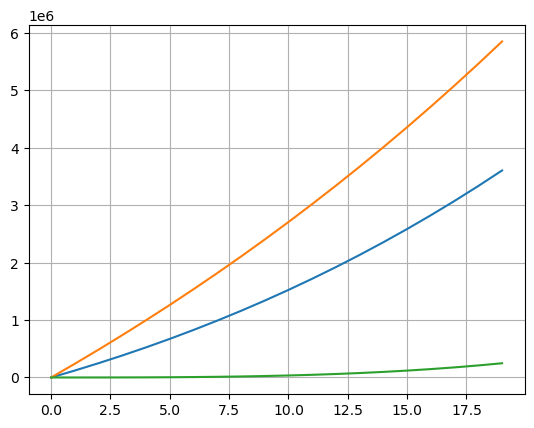

In [75]:
w = cp.random.random(w.shape).astype('float32')
dw0 = cp.random.random(w.shape).astype('float32')/10
v = cp.random.random(3).astype('float32')
dv0 = cp.random.random(3).astype('float32')/10
# phi0 = cp.random.random(1).astype('float32')
# dphi0 = cp.random.random(1).astype('float32')/3

l = cp.linspace(0,5,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dw = l[k]*dw0
    dv = l[k]*dv0
    a = F21([w+dw,v+dv])
    print(cp.linalg.norm(dF21([w,v],[dw,0*dv])),cp.linalg.norm(dF21([w,v],[0*dw,dv])))
    err1[k] = cp.linalg.norm(F21([w,v])-a)
    err2[k] = cp.linalg.norm(F21([w,v])-dF21([w,v],[dw,dv])-a)    
    err3[k] = cp.linalg.norm(F21([w,v])+dF21([w,v],[dw,dv])+0.5*d2F21([w,v],[dw,dv],[dw,dv])-a)
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
plt.show()

### $F_{22}(\phi) = [\cos(\phi_1) \sin(\phi_2), \sin(\phi_1) \sin(\phi_2), \cos(\phi_2)] $

In [78]:
def F22(x):
    w,phi = x
    t1 = cp.cos(phi[0])*cp.sin(phi[1])
    t2 = cp.sin(phi[0])*cp.sin(phi[1])
    t3 = cp.cos(phi[1])    
    return [w,cp.array([t1,t2,t3])]

def dF22(x,y):
    w,phi = x
    dw,dphi = y
    t1 = -cp.sin(phi[0])*cp.sin(phi[1])*dphi[0]+cp.cos(phi[0])*cp.cos(phi[1])*dphi[1]
    t2 = cp.cos(phi[0])*cp.sin(phi[1])*dphi[0]+cp.sin(phi[0])*cp.cos(phi[1])*dphi[1]
    t3 = -cp.sin(phi[1])*dphi[1]
    return [dw,cp.array([t1,t2,t3])]

def dF22adj(x,y):
    w,phi = x
    dw,t1,t2,t3 = y
    
    dphi = cp.zeros([2],dtype='float32')
    dphi[0] = -cp.sin(phi[0])*cp.sin(phi[1])*t1 + cp.cos(phi[0])*cp.sin(phi[1])*t2 
    dphi[1] = cp.cos(phi[0])*cp.cos(phi[1])*t1 + cp.sin(phi[0])*cp.cos(phi[1])*t2 -cp.sin(phi[1]) *t3
    
    return dw,dphi

def d2F22(x,y,z):
    w,phi = x
    dw1,dphi1 = y
    dw2,dphi2 = z
    
    d22 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),-cp.cos(phi[1])])
    d11 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),cp.array(0)])
    d22 = cp.array([-cp.cos(phi[0])*cp.sin(phi[1]),-cp.sin(phi[0])*cp.sin(phi[1]),-cp.cos(phi[1])])
    d12 = cp.array([-cp.sin(phi[0])*cp.cos(phi[1]),-cp.cos(phi[0])*cp.cos(phi[1]),cp.array(0)])
    res =  (dphi1[0]*dphi2[0]*d11+
            dphi1[1]*dphi2[1]*d22+
            (dphi1[0]*dphi2[1]+dphi1[1]*dphi2[0])*d12)
    return [0,res]
  

### Approximation test

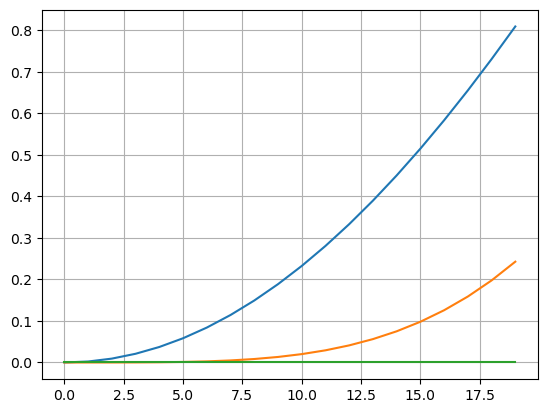

In [86]:
  
w = cp.random.random(w.shape).astype('float32')
dw0 = cp.random.random(w.shape).astype('float32')/10
v = cp.random.random(3).astype('float32')
dv0 = cp.random.random(3).astype('float32')/10
phi = cp.random.random(2).astype('float32')
dphi0 = cp.random.random(2).astype('float32')/3

l = cp.linspace(0,5,20).astype('float32')
err1 = np.zeros(20)
err2 = np.zeros(20)
err3 = np.zeros(20)
for k in range(20):
    dphi = l[k]*dphi0
    dw = 0*dw0
    a = F22([w,phi+dphi])    
    a1 = F22([w,phi])    
    err1[k] = cp.linalg.norm(a1[0]-a[0])**2+cp.linalg.norm(a1[1]-a[1])**2
    a2 = dF22([w,phi],[dw,dphi])
    err2[k] = cp.linalg.norm(a1[0]+a2[0]-a[0])**2+cp.linalg.norm(a1[1]+a2[1]-a[1])**2
    a3 = d2F22([w,phi],[dw,dphi],[dw,dphi])
    err2[k] = cp.linalg.norm(a1[0]+a2[0]+0.5*a3[0]-a[0])**2+cp.linalg.norm(a1[1]+a2[1]+0.5*a3[0]-a[1])**2    
plt.plot(err1,label='f')
plt.plot(err2,label='linear')
plt.plot(err3,label='quadr')
plt.grid()
plt.show()

# debug plot

In [ ]:
def plot_debug(vars, etas, top, bottom, alpha, d, lam):
    """Checking second order approximation"""
    w, phi,a = vars['w'],vars['phi'],vars['a']
    weta, phieta, aeta = etas['w'],etas['phi'],etas['a']
    npp = 9
    errt = cp.zeros(npp * 2)
    errt2 = cp.zeros(npp * 2)
    for k in range(0, npp * 2):
        wt = w + (alpha * k / (npp - 1)) * weta
        phit = phi + (alpha * k / (npp - 1)) * phieta
        at = a + (alpha * k / (npp - 1)) * aeta
        errt[k] = cp.linalg.norm(F1(wt)-d)**2
        errt[k] += lam[0]*cp.linalg.norm(F21([wt,phit]))**2
        errt[k] += lam[1]*(cp.sum((cp.linalg.norm(wt, axis=-1) - at)**2))
        
    t = alpha * (cp.arange(2 * npp)) / (npp - 1)
    errt2 = cp.linalg.norm(F1(w)-d)**2
    errt2 += lam[0]*cp.linalg.norm(F2([w,phi]))**2    
    errt2 += lam[1]*(cp.sum((cp.linalg.norm(w, axis=-1) - a)**2))
    errt2 = errt2 - top * t + 0.5 * bottom * t**2
    print(f'{phi=},{a=}')
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt.get(),
        ".",
        label="real",
    )
    plt.plot(
        (alpha * cp.arange(2 * npp)).get() / (npp - 1),
        errt2.get(),
        ".",
        label="approx",
    )
    plt.legend()
    plt.grid()
    plt.show()

# BH functions

In [ ]:

def gradient(vars,lam,d):
    w,phi,a = vars['w'],vars['phi'],vars['a']

    # first part
    gw = 2*F1adj(F1(w)-d) 
    

    # second part
    gw0,gphi = dF22adj([w,phi],lam[0]*dF21adj([w,phi]))    
    
    # third part 
    mag = cp.linalg.norm(w, axis=-1) + 1e-7    
    gw1 = 2*lam[1]*(w - (a * w / mag[..., None]))
    norm_one = cp.float32(cp.size(w[0,...,0]))
    ga = 2*lam[1]*(-cp.sum(mag) + a * norm_one)
        
    # result
    grads = {}
    grads['w'] = gw + gw0 + gw1
    grads['phi'] = gphi
    grads['a'] = ga
    return grads

def hessian_F1(vars,grads,etas):
    dw1 = grads['w']
    dw2 = etas['w']
    
    F1y = F1(dw1)
    F1z = F1(dw2)     
    t1 = 2*cp.real(cp.sum(F1y*cp.conj(F1z)))  
    return t1

def hessian_F2(vars,grads,etas,lam):
    w,phi = vars['w'],vars['phi']
    dw1,dphi1 = grads['w'],grads['phi']
    dw2,dphi2 = etas['w'],etas['phi']
    
    dF21 = dF2([w,phi],[dw1,dphi1])
    dF22 = dF2([w,phi],[dw2,dphi2])
    t1 = 2*cp.real(cp.sum(dF21*cp.conj(dF22)))
    
    d2F = d2F2([w,phi],[dw1,dphi1],[dw2,dphi2])
    t2 = 2*cp.real(cp.sum(F2([w,phi])*cp.conj(d2F)))
    return lam*(t1+t2)

def hessian_F3(vars,grads,etas, lam):    
    w,a = vars['w'],vars['a']
    dw1,da1 = grads['w'],grads['a']
    dw2,da2 = etas['w'],etas['a']

    mag = cp.linalg.norm(w, axis=-1) + cp.float32(1e-7)
    
    w_hat = w / mag[..., None]
    proj1 = cp.sum(w_hat * dw1, axis=-1)
    proj2 = cp.sum(w_hat * dw2, axis=-1)
    scal12 = cp.sum(dw1 * dw2, axis=-1)
    norm_one = cp.float32(cp.size(w[0,...,0]))
    term_da = norm_one * da1 * da2 \
              - cp.sum(w_hat * dw1) * da2 \
              - cp.sum(w_hat * dw2) * da1
    term_w = cp.sum((cp.float32(1.0) - a / mag) * scal12) + cp.sum((a / mag) * (proj1 * proj2))
    return 2 * lam* (term_da + term_w)

def hessian(vars,grads,etas,lam):
    return (hessian_F1(vars,grads,etas)+
            hessian_F2(vars,grads,etas,lam[0])+
            hessian_F3(vars,grads,etas,lam[1]))

def calc_err(vars,lam,d):
    w,phi,a = vars['w'],vars['phi'],vars['a']
    err = (cp.linalg.norm(F1(w)-d)**2+
           lam[0]*cp.linalg.norm(F2([w,phi]))**2+
           lam[1]*(cp.sum((cp.linalg.norm(w, axis=-1) - a)**2)))
    return err

def BH(vars, d, niter,lam):
    err = cp.zeros(niter)
    for i in range(niter):
        
        if i%8==0:
            err[i] = calc_err(vars,lam,d)
            print(i,f'err={err[i]}')
        grads = gradient(vars,lam,d)
        
        if i == 0:
            etas = {}
            etas['w'] = -grads['w']
            etas['phi'] = -grads['phi']
            etas['a'] = -grads['a']
        else:
            top = hessian(vars,grads,etas,lam)
            bottom = hessian(vars,etas,etas,lam)
            beta = top / bottom
            etas['w'] = etas['w'] * beta - grads['w']
            etas['phi'] = etas['phi'] * beta - grads['phi']
            etas['a'] = etas['a'] * beta - grads['a']            
            
        top = (-cp.sum(grads['w']*cp.conj(etas['w'])).real
               -cp.sum(grads['phi']*cp.conj(etas['phi'])).real
               -cp.sum(grads['a']*cp.conj(etas['a'])).real)
        bottom = hessian(vars, etas, etas,lam)
        alpha = top / bottom
        # print(alpha,top,bottom)
        if i%8==0:
            plot_debug(vars,etas,top,bottom,alpha,d,lam)

        vars['w'] += alpha * etas['w']
        vars['phi'] += alpha * etas['phi']
        vars['a'] += alpha * etas['a']       
    return vars,err


0 err=0.92458575963974
phi=np.float32(0.0),a=np.float32(0.0)


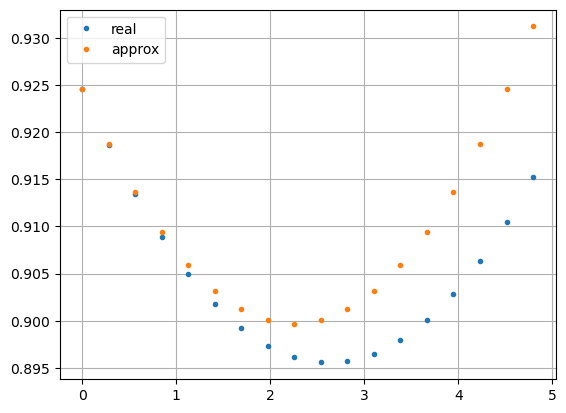

8 err=0.8935641646385193
phi=array(-2.1532696e-05, dtype=float32),a=array(0.00082187, dtype=float32)


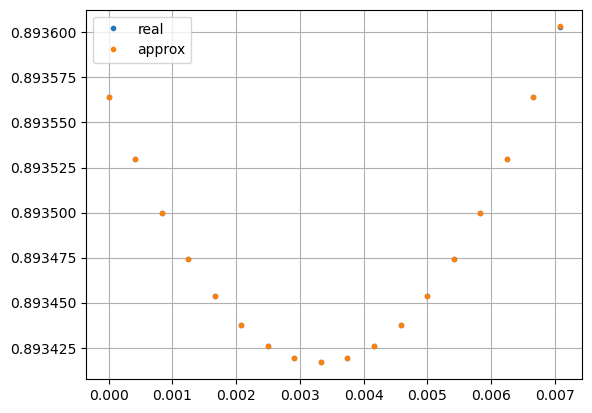

16 err=0.8932386040687561
phi=array(-6.452427e-05, dtype=float32),a=array(0.00068471, dtype=float32)


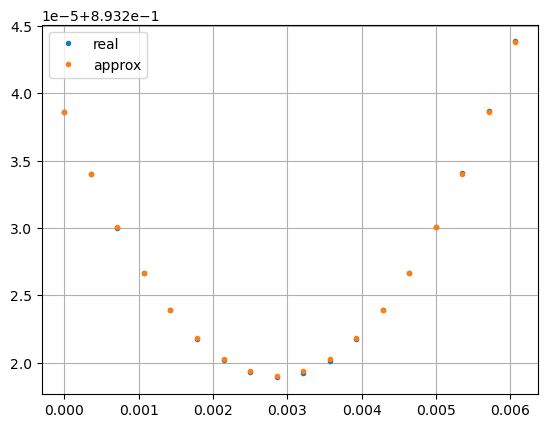

24 err=0.8931720852851868
phi=array(-0.00011079, dtype=float32),a=array(0.00067771, dtype=float32)


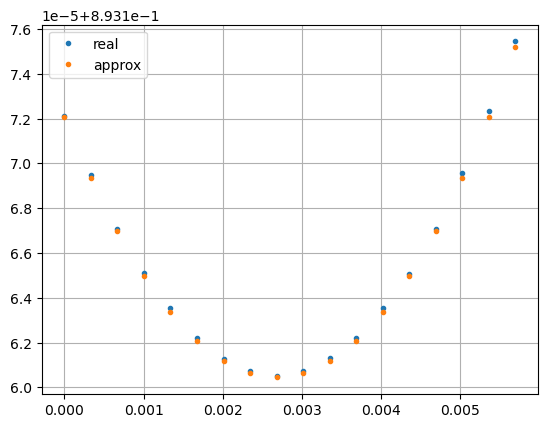

32 err=0.8931248784065247
phi=array(-0.00016818, dtype=float32),a=array(0.00070487, dtype=float32)


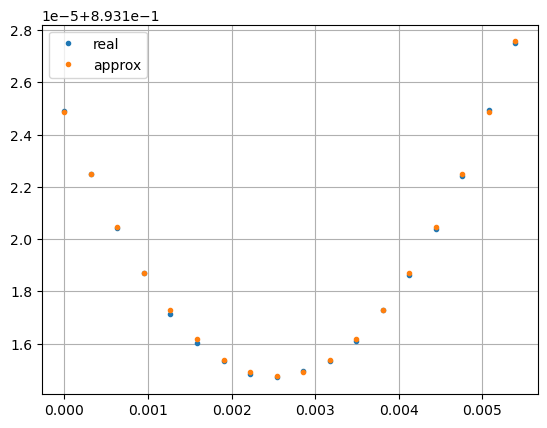

40 err=0.8930811285972595
phi=array(-0.00023899, dtype=float32),a=array(0.00075356, dtype=float32)


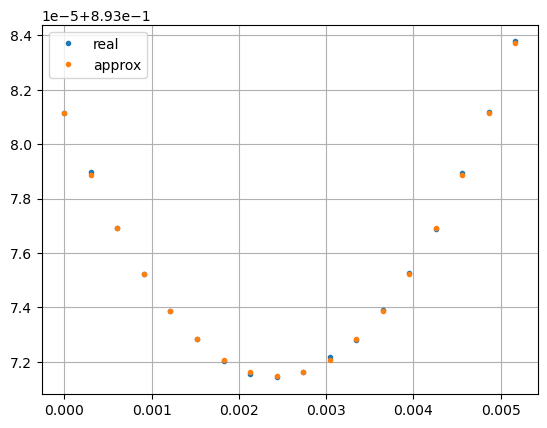

48 err=0.8930394649505615
phi=array(-0.00032033, dtype=float32),a=array(0.00081348, dtype=float32)


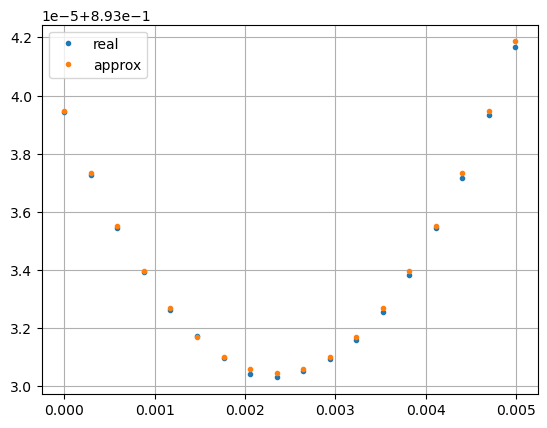

56 err=0.8930015563964844
phi=array(-0.00040503, dtype=float32),a=array(0.00087222, dtype=float32)


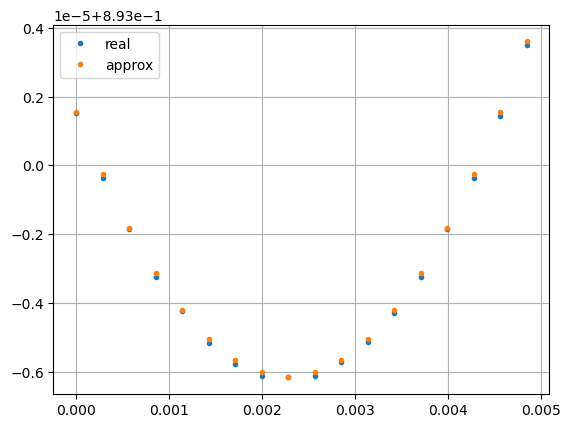

64 err=0.892970085144043
phi=array(-0.00048561, dtype=float32),a=array(0.00091975, dtype=float32)


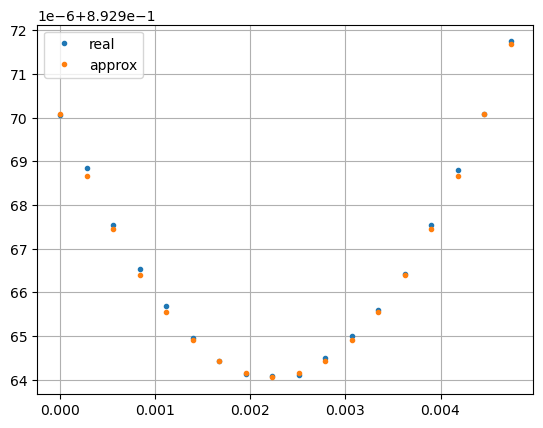

72 err=0.8929460048675537
phi=array(-0.00055945, dtype=float32),a=array(0.00095279, dtype=float32)


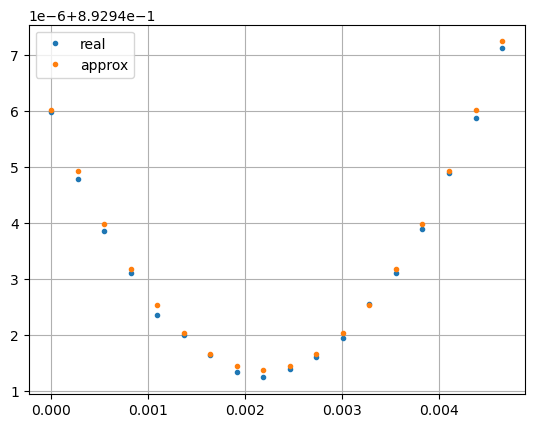

80 err=0.8929270505905151
phi=array(-0.00062963, dtype=float32),a=array(0.00097313, dtype=float32)


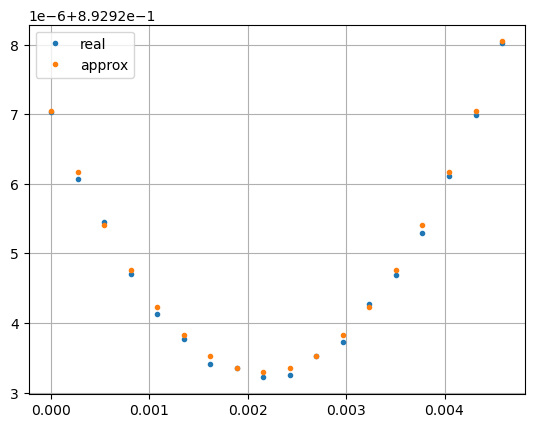

88 err=0.8929110169410706
phi=array(-0.00070262, dtype=float32),a=array(0.00098355, dtype=float32)


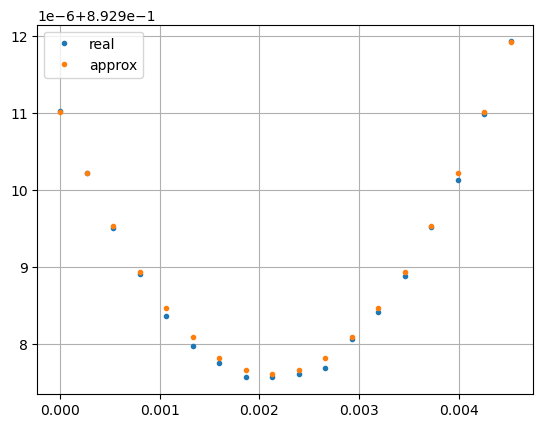

96 err=0.8928958177566528
phi=array(-0.0007864, dtype=float32),a=array(0.00098552, dtype=float32)


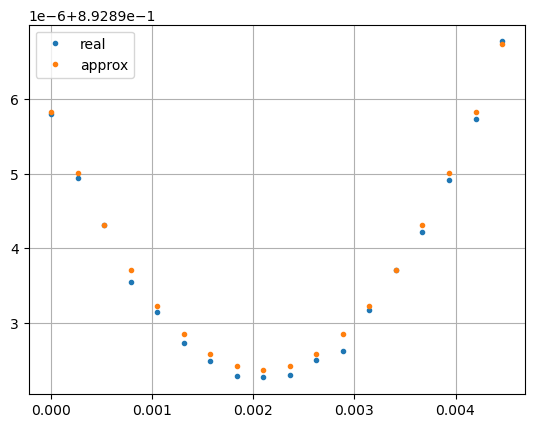

104 err=0.8928797245025635
phi=array(-0.00088937, dtype=float32),a=array(0.00097893, dtype=float32)


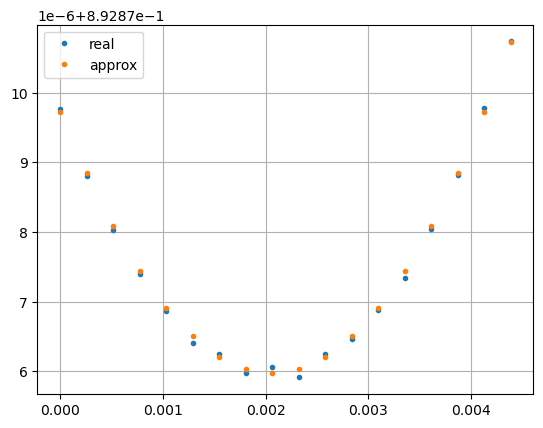

112 err=0.8928619623184204
phi=array(-0.00101833, dtype=float32),a=array(0.00096285, dtype=float32)


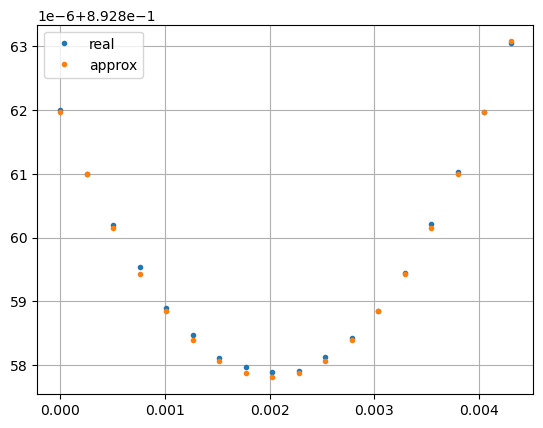

120 err=0.8928425908088684
phi=array(-0.00117494, dtype=float32),a=array(0.00093692, dtype=float32)


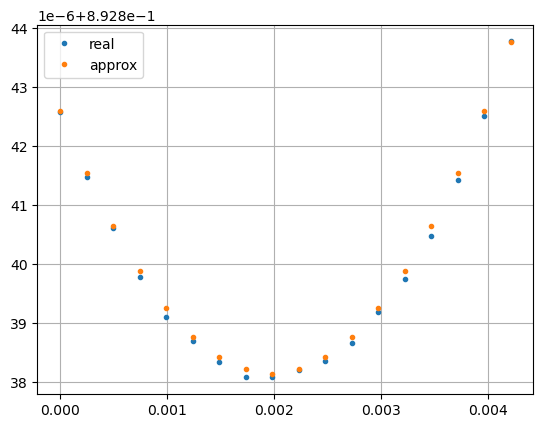

128 err=0.8928220272064209
phi=array(-0.0013529, dtype=float32),a=array(0.00090265, dtype=float32)


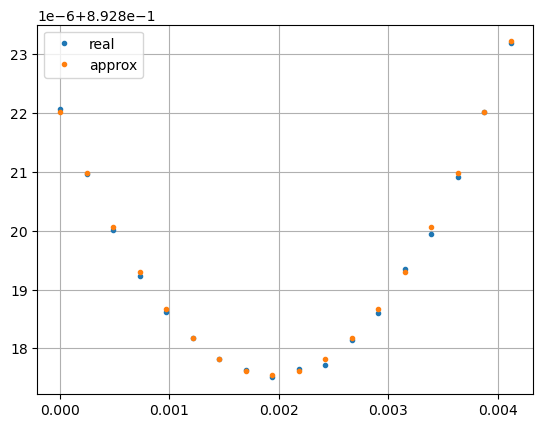

136 err=0.8928018808364868
phi=array(-0.00153892, dtype=float32),a=array(0.00086365, dtype=float32)


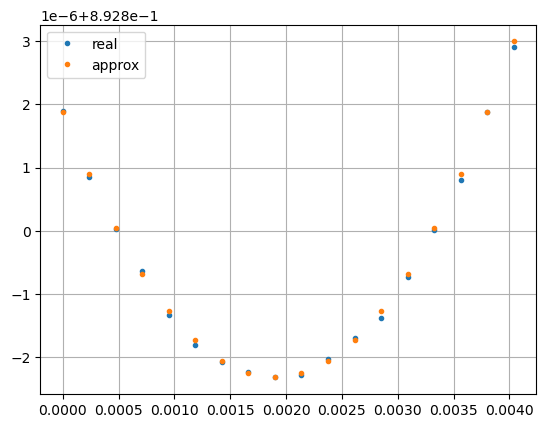

144 err=0.8927834033966064
phi=array(-0.00171814, dtype=float32),a=array(0.0008245, dtype=float32)


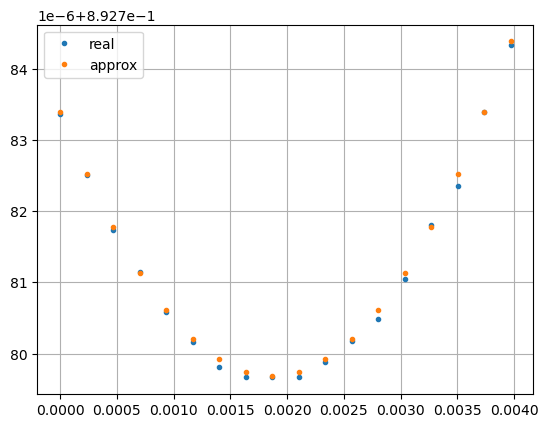

152 err=0.8927673101425171
phi=array(-0.00188021, dtype=float32),a=array(0.00078917, dtype=float32)


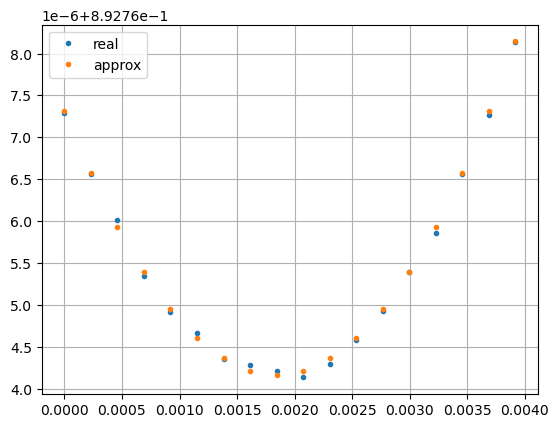

160 err=0.8927538394927979
phi=array(-0.00202194, dtype=float32),a=array(0.00076001, dtype=float32)


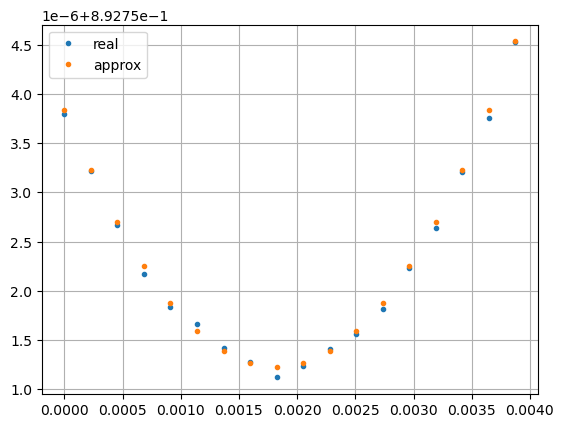

168 err=0.8927425146102905
phi=array(-0.00214621, dtype=float32),a=array(0.00073777, dtype=float32)


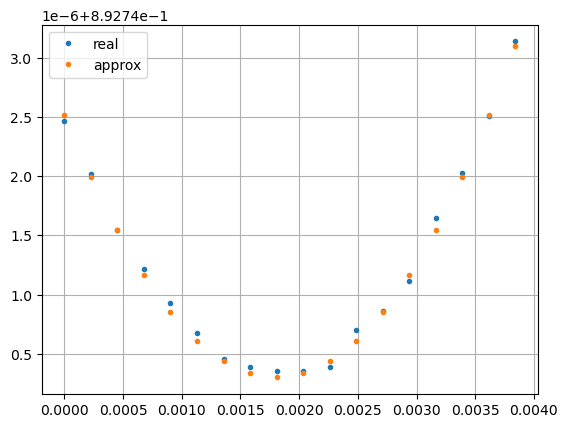

176 err=0.8927328586578369
phi=array(-0.00225938, dtype=float32),a=array(0.00072222, dtype=float32)


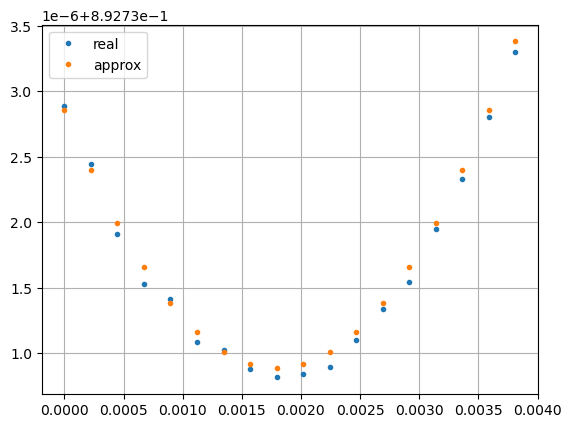

184 err=0.8927239179611206
phi=array(-0.00236895, dtype=float32),a=array(0.00071288, dtype=float32)


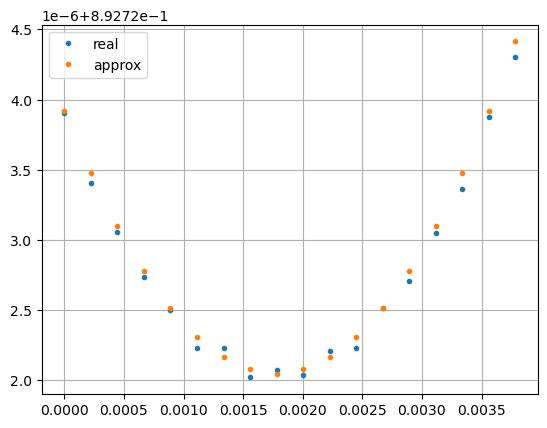

192 err=0.8927151560783386
phi=array(-0.00248236, dtype=float32),a=array(0.00070953, dtype=float32)


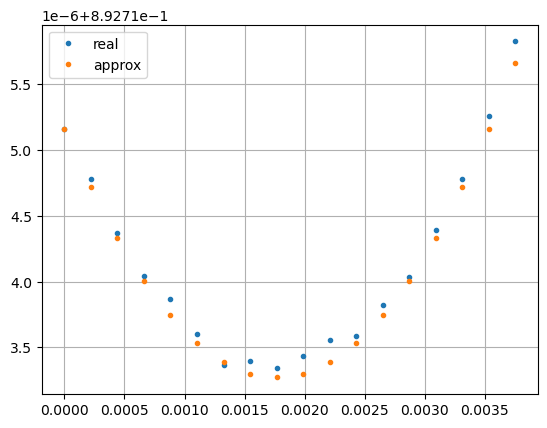

200 err=0.8927063345909119
phi=array(-0.00260628, dtype=float32),a=array(0.00071228, dtype=float32)


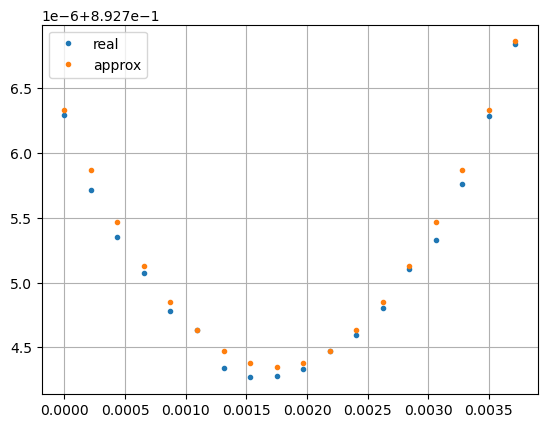

208 err=0.8926966190338135
phi=array(-0.00274584, dtype=float32),a=array(0.00072146, dtype=float32)


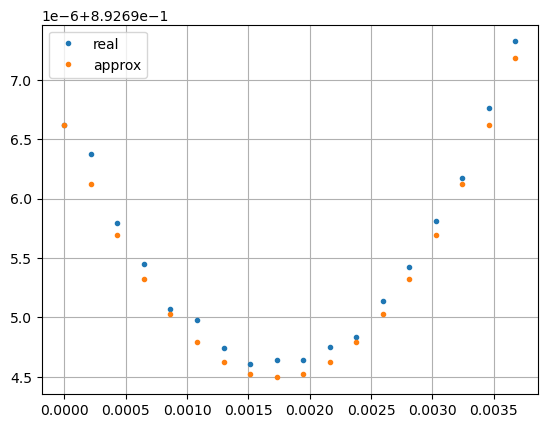

216 err=0.8926863670349121
phi=array(-0.00290349, dtype=float32),a=array(0.00073713, dtype=float32)


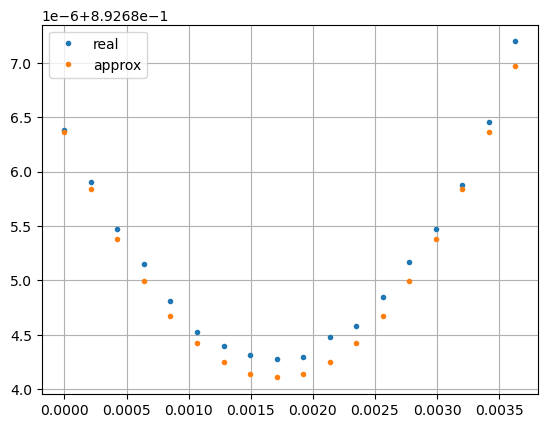

224 err=0.8926755785942078
phi=array(-0.00307797, dtype=float32),a=array(0.00075869, dtype=float32)


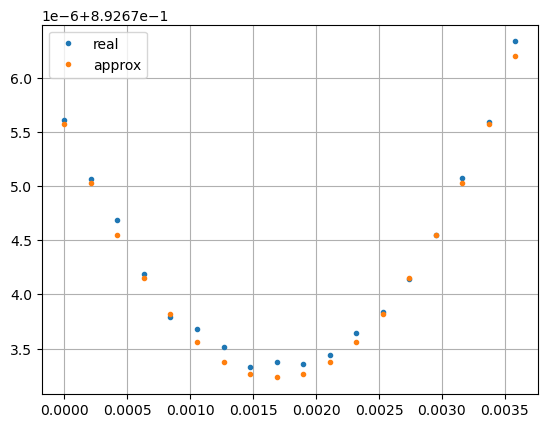

232 err=0.8926645517349243
phi=array(-0.00326406, dtype=float32),a=array(0.00078458, dtype=float32)


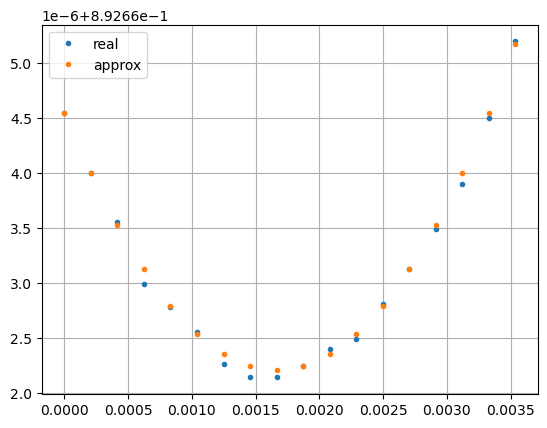

240 err=0.8926535844802856
phi=array(-0.00345378, dtype=float32),a=array(0.0008125, dtype=float32)


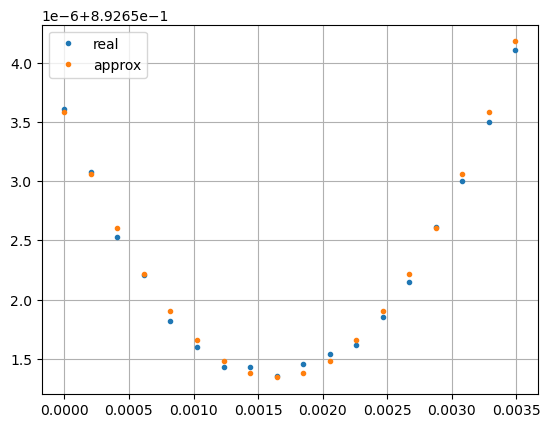

248 err=0.8926432132720947
phi=array(-0.00363874, dtype=float32),a=array(0.00084002, dtype=float32)


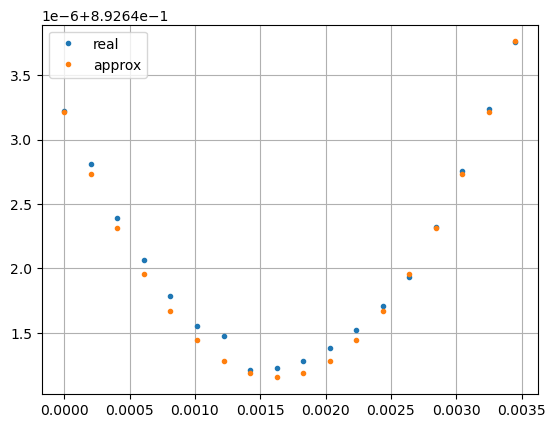

256 err=0.8926339149475098
phi=array(-0.00381274, dtype=float32),a=array(0.00086513, dtype=float32)


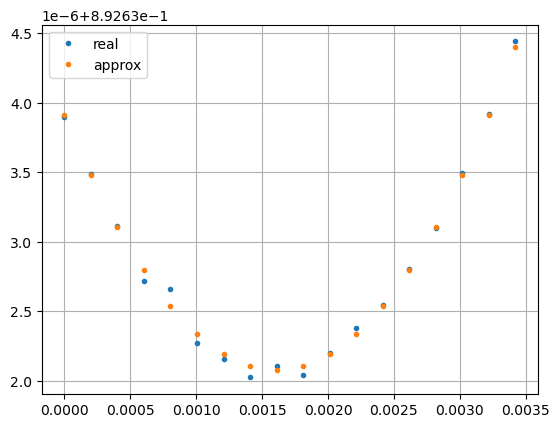

vars['phi']=array(-0.0038476, dtype=float32)


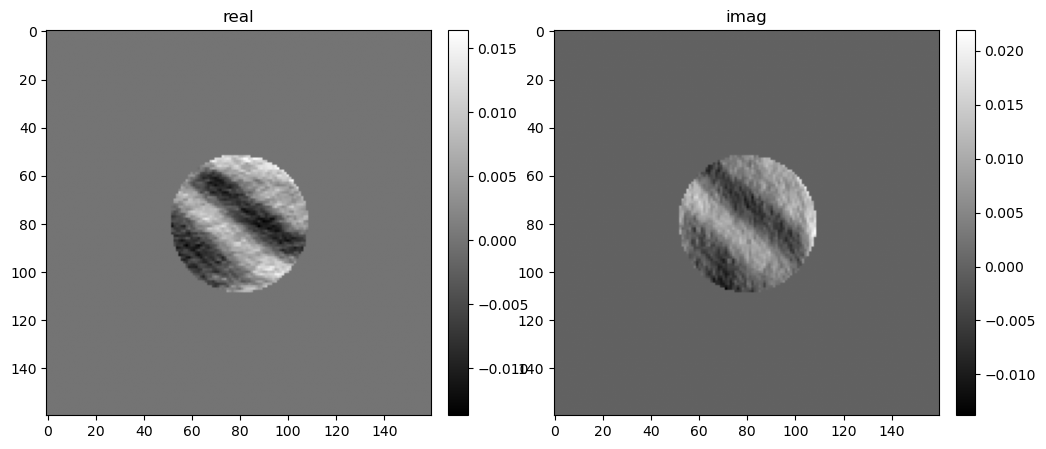

In [31]:
# initial guess
vars = {}
vars['w'] = w*0
vars['phi'] = cp.float32(0)
vars['a'] = cp.float32(0)
lam = [0.0003,0.1]
niter = 257
vars,err2 = BH(vars,data,niter,lam)

print(f'{vars['phi']=}')
mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1])

0.00085933844


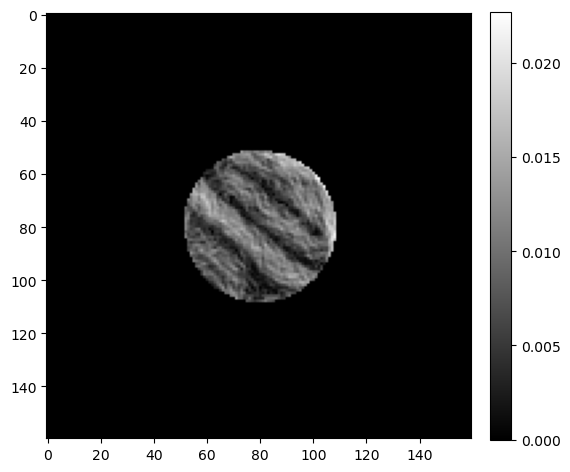

In [32]:
# mshow_complex(vars['w'][0,:,:,0]+1j*vars['w'][0,:,:,1])
print(vars['a'])
mshow(cp.linalg.norm(vars['w'][0],axis=-1),True)

In [9]:
# vars['phi']

In [10]:
# err = cp.zeros(360)
# p = cp.linspace(-cp.pi,cp.pi,360).astype('float32')
# for k in range(360):
#     err[k] = cp.linalg.norm(F2([vars['w'],p[k]]))
#     # mshow(F2([vars['w'],vars['phi']])[80])
#     # mshow((F1(vars['w'])-data)[:,80])
#     # mshow(data[:,80])
# plt.plot(p.get(),err)
# plt.plot(vars['phi'].get(),cp.linalg.norm(F2([vars['w'],vars['phi']])).get(),'rx')

